In [276]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", None)

In [277]:
#creating a function to find SMA for n period 
def sma(data,period):
      return data.rolling(period).mean()

In [278]:
# start='2023-06-20'
# end='2023-08-12'
# data=yf.download("CL=F", start, end, interval="30m")

In [279]:
symbol = 'CL=F'
start = '2023-06-20'
end = '2023-08-14'
data=yf.download(symbol,start,end, interval="15m")

[*********************100%***********************]  1 of 1 completed


In [280]:
#function to find RSI of n period 
def rsi(data,period): 
    change = data.diff(1)
    gain = change.mask(change<0,0)
    loss = abs(change.mask(change>0,0))
    avg_gain = gain.rolling(period).mean()
    avg_loss= loss.rolling(period).mean()
    rs = avg_gain/avg_loss
    return ( 100 - (100/(1+rs)))

In [281]:
def slope(x,y): 
    dif=x-y
    if dif>=0: 
        return False
    else: 
        return True
    

In [282]:
data["RSI"]=rsi(data["Close"], 7)
data["SMA7"]=sma(data["Close"],14)
data["SMA20"]=sma(data["Close"],20)
data["entry_long"]=""
data["exit_long"]=""
data["entry_short"]=""
data["exit_short"]=""
data["stop_loss"]=""
data["target"]=""
data["trade_type"]=""
global no_trade
no_trade=0
p_l_short=[]
p_l_long=[]
p_l=[]

In [283]:

def short_trade(data): 
    
    in_trade=False 
    rsi_threshold=35
    sl_multiplier=3
    sl_candles=5
    
    for i in range(len(data)):
        if  i>0 and data['Close'][i] < data["SMA7"][i] and slope(data["SMA20"][i], data["SMA20"][i-1])  and data['RSI'][i] < rsi_threshold and in_trade==False:
            if not in_trade:
                in_trade = True
                data["entry_short"][i] = data['Close'][i]
                entry_price=data["Close"][i]
                stop_loss = data['High'][i - 1:i - 1 - sl_candles:-1].max()
                data["stop_loss"][i]=stop_loss                                
                target = entry_price - ((stop_loss-entry_price ) * sl_multiplier)  
                data["target"][i]=target
                data["trade_type"][i]="short"
                
        elif in_trade and data['High'][i] >= stop_loss:
                data["exit_short"][i]=stop_loss
                data["trade_type"][i]="stop_loss_short"
                p_l_short.append(entry_price-stop_loss)
                p_l.append(entry_price-stop_loss)
                in_trade = False
                entry_price = 0
                stop_loss = 0
                target = 0
     
        elif in_trade and data['Close'][i] <= target:
                data["exit_short"][i]=target
                data["trade_type"][i]="Target_short"
                p_l_short.append(entry_price-target)
                p_l.append(entry_price-target)
                in_trade = False
                entry_price = 0
                stop_loss = 0
                target = 0

        
        

In [284]:

def long_trade(data):
    
    rsi_threshold=70
    sl_multiplier=3
    sl_candles=5
    in_trade=False 
    
    for i in range(len(data)):
        if  i>0 and data['Close'][i] > data["SMA7"][i] and not slope(data["SMA20"][i], data["SMA20"][i-1])  and data['RSI'][i] > rsi_threshold and in_trade==False:
            if not in_trade:
                in_trade = True
                data["entry_long"][i] = data['Close'][i]
                entry_price=data["Close"][i]
                stop_loss = data['Low'][i - 1:i - 1 - sl_candles:-1].min()
                data["stop_loss"][i]=stop_loss                                
                target = entry_price + ((entry_price - stop_loss) * sl_multiplier)  
                data["target"][i]=target
                data["trade_type"][i]="long"
                
        elif in_trade and data['High'][i] <= stop_loss:
                data["exit_long"][i]=stop_loss
                data["trade_type"][i]="stop_loss_long"
                p_l_long.append(stop_loss-entry_price)
                p_l.append(stop_loss-entry_price)
        
                
                in_trade = False
                entry_price = 0
                stop_loss = 0
                target = 0
     
        elif in_trade and data['Close'][i] >= target:
                data["exit_long"][i]=target
                data["trade_type"][i]="Target_long" 
                p_l_long.append(target-entry_price)
                p_l.append(target-entry_price)
                in_trade = False
                entry_price = 0
                stop_loss = 0
                target = 0

In [285]:
short_trade(data)
long_trade(data)

<ipython-input-283-81be65c49894>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["entry_short"][i] = data['Close'][i]
<ipython-input-283-81be65c49894>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["stop_loss"][i]=stop_loss
<ipython-input-283-81be65c49894>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["target"][i]=target
<ipython-input-283-81be65c49894>:18: SettingWithCopyWarning: 
A value is trying to be set on

In [296]:
#no. of winning trades in long
loosing_long=0
loss_long=0
win_long=0
loss_short=0
winning_short=0
win_short=0
winning_long=0
loosing_short=0

for i in p_l_long: 
    if i< 0: 
        loosing_long+=1
        loss_long+=i
    else: 
        winning_long+=1
        win_long+=i
        
for i in p_l_short: 
    if i< 0: 
        loosing_short+=1
        loss_short+=i
    else: 
        winning_short+=1
        win_short+=i
        
cum_long=[]
cum_short=[]
cum_p_l=[]
sumo=0
max_drawback=0
for i in p_l_long:
    sumo=sumo+i
    cum_long.append(sumo)

sumo=0
for i in p_l_short:
    sumo=sumo+i
    cum_short.append(sumo)

sumo=0
max_drawback=1000
for i in p_l:
    temp=sumo
    sumo=sumo+i
    cum_p_l.append(sumo)
    if(sumo<temp): 
        max_drawback=min(sumo-temp, max_drawback)
    
    
# time_all=data.index[data["Trade_type"]!=" long" or data["Trade_type"]!="short" or data["Trade_type"]!="" ]

# time_long=data.index[data["trade_type"]=="Target_long" or data["trade_type"]=="stop_loss_long" ]

# time_short=data.index[ data["trade_type"]=="stop_loss_short" or data["trade_type"]=="Target_short" ]



    


#no. of trades 

no_trades=len(p_l_short)+len(p_l_long)
no_short_trades=len(p_l_short)
no_long_trades=len(p_l_long)
no_win_long_trades=winning_long
no_win_short_trades=winning_short
no_loss_long_trades=loosing_long
no_loss_short_trades=loosing_short
total_win_trades=no_win_short_trades + no_win_long_trades
total_loss_trades=no_loss_short_trades+no_loss_long_trades
hit_ratio=total_win_trades/no_trades
total_win_p_long=win_long
total_loss_p_long=loss_long
total_win_p_short=win_short
total_loss_p_short=loss_short
total_profit= total_win_p_long+total_win_p_short
total_loss=total_loss_p_long+total_loss_p_short


final={ "number of trades": no_trades, 
       " number of short trades": no_short_trades, 
       " number of long trades" : no_long_trades, 
        " number of winning long trades": no_win_long_trades,
       " number of loosing long trades": no_loss_long_trades,
       " number of winning short trades": no_win_short_trades,
       " number of loosing short trades": no_loss_short_trades,
       "Total win trades": total_win_trades, 
       " Total loose trades": total_loss_trades, 
       "hit ratio": hit_ratio, 
       "profit in long trade": total_win_p_long, 
       " profit in short trade": total_win_p_short,
       " loss in long trade": total_loss_p_long,
       " loss in short trade": total_loss_p_short, 
       "total profit": total_profit,
       "total loss": total_loss,
       "net profit": total_profit+total_loss,
       "maximum_drawback": max_drawback,
       "time period": data.index[-1]- data.index[0]
      }
       
       
       
      
       






Text(0.5, 1.0, 'Long Trade Equity Curve')

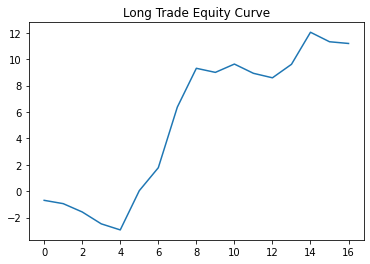

In [297]:
plt.plot( cum_long)
plt.title("Long Trade Equity Curve")


Text(0.5, 1.0, 'Short Trade Equity Curve')

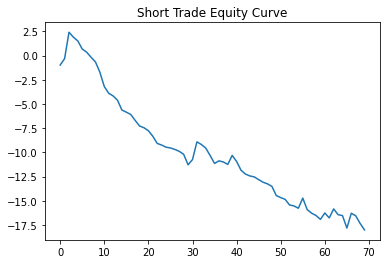

In [298]:
plt.plot( cum_short)
plt.title("Short Trade Equity Curve")


Text(0.5, 1.0, 'Equity_curve')

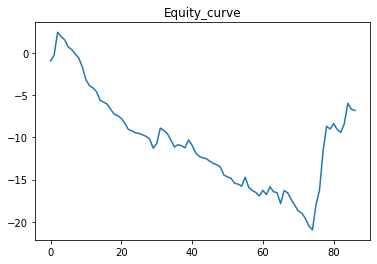

In [299]:
plt.plot(cum_p_l)
plt.title("Equity_curve")

In [300]:
final

{'number of trades': 87,
 ' number of short trades': 70,
 ' number of long trades': 17,
 ' number of winning long trades': 7,
 ' number of loosing long trades': 10,
 ' number of winning short trades': 10,
 ' number of loosing short trades': 60,
 'Total win trades': 17,
 ' Total loose trades': 70,
 'hit ratio': 0.19540229885057472,
 'profit in long trade': 16.320030212402344,
 ' profit in short trade': 11.129974365234375,
 ' loss in long trade': -5.1299896240234375,
 ' loss in short trade': -29.139991760253906,
 'total profit': 27.45000457763672,
 'total loss': -34.269981384277344,
 'net profit': -6.819976806640625,
 'maximum_drawback': -1.4799957275390625,
 'time period': Timedelta('54 days 23:45:00')}

In [275]:
data

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA7,SMA20,entry_long,exit_long,entry_short,exit_short,stop_loss,target,trade_type
Datetime,,,,,,,,,,,,,,,,
2023-06-20 00:00:00,70.910004,70.919998,70.879997,70.879997,70.879997,1,NaN,NaN,NaN,,,,,,,
2023-06-20 01:00:00,70.860001,70.860001,70.860001,70.860001,70.860001,825,NaN,NaN,NaN,,,,,,,
2023-06-20 01:15:00,70.790001,70.790001,70.769997,70.790001,70.790001,20,NaN,NaN,NaN,,,,,,,
2023-06-20 01:30:00,70.760002,70.760002,70.760002,70.760002,70.760002,6,NaN,NaN,NaN,,,,,,,
2023-06-20 02:00:00,70.760002,70.760002,70.750000,70.760002,70.760002,7,NaN,NaN,NaN,,,,,,,
2023-06-20 02:30:00,70.949997,70.949997,70.940002,70.940002,70.940002,2,NaN,NaN,NaN,,,,,,,
2023-06-20 02:45:00,71.029999,71.029999,71.029999,71.029999,71.029999,4,NaN,NaN,NaN,,,,,,,
2023-06-20 03:00:00,71.220001,71.220001,71.220001,71.220001,71.220001,5,79.310980,NaN,NaN,,,,,,,
2023-06-20 03:30:00,71.279999,71.279999,71.250000,71.250000,71.250000,4,83.051001,NaN,NaN,,,,,,,


TypeError: bar() missing 1 required positional argument: 'height'